In [1]:
from os import listdir, mkdir
from os.path import isfile, join, isdir
from json import loads
from re import findall,UNICODE
import sys
sys.path.append("/Users/andyreagan/tools/python")
from kitchentable.dogtoys import *
from labMTsimple.labMTsimple.speedy import LabMT
my_LabMT = LabMT()
from labMTsimple.labMTsimple.storyLab import *
import numpy as np
import pickle

import os
sys.path.append('/Users/andyreagan/projects/2014/09-books/database')
os.environ.setdefault('DJANGO_SETTINGS_MODULE','gutenbergdb.settings')
import django
django.setup()

from library.models import *
from bookclass import *

from tqdm import tqdm

In [2]:
# all our essentials
from matplotlib import rc,rcParams
# rc('font', family='sans-serif') 
# rc('font', serif='Helvetica Neue')
# rc('text', usetex='false') 

rc('font', family='serif')
rc('font', family='cmr10')
rc('text', usetex='true') 

rcParams.update({'font.size': 12})
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics

In [4]:
filters = {"min_dl":40,
           "length": [20000,100000],
           "P": True,
           "n_points": 200,
           "salad": False,
          }
q = get_books(Book,filters)
version_str = get_version_str(filters)
this_dir = join("/Users/andyreagan/projects/2014/09-books/media/figures/clustering",version_str)
if not isdir(this_dir):
    mkdir(this_dir)
big_matrix = get_data(q,version_str,filters,use_cache=True)
big_matrix_mean0 = big_matrix-np.tile(big_matrix.mean(axis=1),(200,1)).transpose()
big_matrix_start0 = big_matrix-np.tile(big_matrix[:,0],(200,1)).transpose()
print(big_matrix.shape)

(1385, 200)


In [5]:
# pre compute the full distance matrix
# ouch

# the city block distance betwen two vectors
def cityBlock(a,b):
    return np.sum(np.abs(a-b))

# define a quick cache for this one...
if isfile("/Users/andyreagan/projects/2014/09-books/data/gutenberg/pairwise-distance-matrix-cache-{}.p".format(version_str)):
    allDistances = pickle.load(open("/Users/andyreagan/projects/2014/09-books/data/gutenberg/pairwise-distance-matrix-cache-{}.p".format(version_str),"rb"))
    allDistancesCentered = pickle.load(open("/Users/andyreagan/projects/2014/09-books/data/gutenberg/pairwise-distance-mean0-matrix-cache-{}.p".format(version_str),"rb"))
    allDistancesStart = pickle.load(open("/Users/andyreagan/projects/2014/09-books/data/gutenberg/pairwise-distance-start0-matrix-cache-{}.p".format(version_str),"rb"))
else:
    pairWiseDistances = np.zeros([big_matrix.shape[0],big_matrix.shape[0]])
    pairWiseDistancesCentered = np.zeros([big_matrix_mean0.shape[0],big_matrix_mean0.shape[0]])
    pairWiseDistancesStart = np.zeros([big_matrix_start0.shape[0],big_matrix_start0.shape[0]])
    for i in range(big_matrix.shape[0]):
        if i%100 == 0:
            print(i)
        # compute only the upper diagonal
        for j in range(i,big_matrix.shape[0]):
            pairWiseDistances[i,j] = cityBlock(big_matrix[i,:],big_matrix[j,:])
            pairWiseDistancesCentered[i,j] = cityBlock(big_matrix_mean0[i,:],big_matrix_mean0[j,:])
            pairWiseDistancesStart[i,j] = cityBlock(big_matrix_start0[i,:],big_matrix_start0[j,:])
    # build the full matrices
    allDistances = pairWiseDistances+np.transpose(pairWiseDistances)
    allDistancesCentered = pairWiseDistancesCentered+np.transpose(pairWiseDistancesCentered)
    allDistancesStart = pairWiseDistancesStart+np.transpose(pairWiseDistancesStart)

In [6]:
pickle.dump(allDistances,open("/Users/andyreagan/projects/2014/09-books/data/gutenberg/pairwise-distance-matrix-cache-{}.p".format(version_str),"wb"),pickle.HIGHEST_PROTOCOL)
pickle.dump(allDistancesCentered,open("/Users/andyreagan/projects/2014/09-books/data/gutenberg/pairwise-distance-mean0-matrix-cache-{}.p".format(version_str),"wb"),pickle.HIGHEST_PROTOCOL)
pickle.dump(allDistancesStart,open("/Users/andyreagan/projects/2014/09-books/data/gutenberg/pairwise-distance-start0-matrix-cache-{}.p".format(version_str),"wb"),pickle.HIGHEST_PROTOCOL)

In [7]:
method = 'ward'
metric = 'euclidean'

from scipy.cluster.hierarchy import dendrogram,linkage
fit = linkage(allDistancesCentered,metric=metric,method=method)

In [8]:
# let's try to understand this matrix fit
# A 4 by (n-1) matrix Z is returned.
print(allDistances.shape)
print(fit.shape)
print("this is (n-1) by 4, as expected")
print("-"*20)

# At the i-th iteration, clusters with indices Z[i, 0] and Z[i, 1] 
# are combined to form cluster n + i.
print("...so at iteration n+i, fit[-1,:] we find:")
print(fit[-1,:])
print("-"*20)
# old indices:
# this means clusters 6152 and 6153 were combined to form cluster 3077+3077=6154
# new indices?
# this means clusters fit[-1,0] and fit[-1,1] were combined to form cluster 1755+1755=3510

# A cluster with an index less than n corresponds to one of the original observations.
#...so cluster 0, cluster 3000 are the books at 0, and 3000, themselves

# The distance between clusters Z[i, 0] and Z[i, 1] is given by Z[i, 2].
# ...so the distance between clusters 6152 and 6153 is 72466

# The fourth value Z[i, 3] represents the number of original observations in the newly formed cluster.
# ...and, we now have all of the books in that cluster

print(fit[0,:])
print(fit[1,:])
print("...")
print(fit[-2,:])
print(fit[-1,:])

(1385, 1385)
(1384, 4)
this is (n-1) by 4, as expected
--------------------
...so at iteration n+i, fit[-1,:] we find:
[ 2766.          2767.          7571.55836013  1385.        ]
--------------------
[ 245.          340.            1.36383949    2.        ]
[ 240.          338.            3.65490128    2.        ]
...
[ 2763.          2765.          5028.69161051   495.        ]
[ 2766.          2767.          7571.55836013  1385.        ]


In [52]:
def get_cluster_from_t(t):
    i = np.where(fit[:,2] == t)
    # return i[0][0]
    return i[0][0]+allDistancesCentered.shape[0]
print(get_cluster_from_t(fit[100,2]))

1485


In [48]:
allDistancesCentered.shape[0]

1385

In [9]:
# define a threshold
threshold = 70000
# and we'll go get all of the clusters that are merged under that threshold
# ...this has the effect of slicing the dendrogram at any height

def get_cluster_indices(model,threshold=70000,return_cluster_names=False):
    cluster_list = np.array([i for i in range(allDistances.shape[0])])
    for i,merge in enumerate(model):
        if merge[2] < threshold:
            # print(merge)
            # print(int(merge[0]))
            a = cluster_list==int(merge[0])
            cluster_list[cluster_list==int(merge[0])] = i+allDistances.shape[0]
            cluster_list[cluster_list==int(merge[1])] = i+allDistances.shape[0]
    # print(cluster_list[:10])
    # print(cluster_list[1730:1740])
    clusters = np.unique(cluster_list)
    a = np.arange(allDistances.shape[0])
    indices = [a[cluster_list==c] for c in clusters]
    num_clusters = len(indices)
    cluster_sizes = list(map(len,indices))
    # print('found {0} clusters of sizes:'.format(num_clusters))
    # print(cluster_sizes)
    if return_cluster_names:
        return indices,num_clusters,cluster_sizes,cluster_list
    else:
        return indices,num_clusters,cluster_sizes
    
def get_cluster_indices_from_id(model,cluster_id):
    if cluster_id < allDistances.shape[0]:
        return np.array([cluster_id])
    cluster_list = np.array([i for i in range(allDistances.shape[0])])
    for i,merge in enumerate(model):
        if merge[2] <= model[cluster_id-allDistances.shape[0]+1,2]:
            # print(merge)
            # print(int(merge[0]))
            a = cluster_list==int(merge[0])
            cluster_list[cluster_list==int(merge[0])] = i+allDistances.shape[0]
            cluster_list[cluster_list==int(merge[1])] = i+allDistances.shape[0]
    a = np.arange(allDistances.shape[0])
    # print(cluster_list)
    indices = a[cluster_list==cluster_id]
    return indices

ind,nc,cs = get_cluster_indices(fit,threshold=5000)
ind,nc,cs,cluster_list = get_cluster_indices(fit,threshold=5000,return_cluster_names=True)

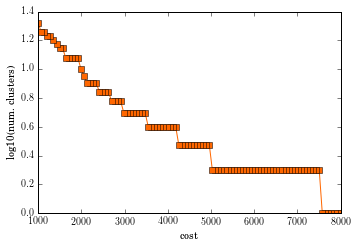

In [10]:
x = np.linspace(8000,1000,num=100)
y = np.zeros([100,1])
for i,cost in enumerate(x):
    ind,nc,cs = get_cluster_indices(fit,threshold=cost)
    y[i] = nc
fig = plt.figure()
ax = fig.add_axes([.2,.2,.7,.7])
ax.plot(x,np.log10(y),'s-',color='#ff6700')
ax.set_ylabel('log10(num. clusters)')
ax.set_xlabel('cost')
# mysavefig('heirarchal-clustering-cost.svg')

In [11]:
R = dendrogram(fit,distance_sort='ascending',no_plot=True,truncate_mode='lastp')

In [12]:
# R = dendrogram(fit,distance_sort='ascending')

In [14]:
ind,nc,cs,cluster_list = get_cluster_indices(fit,threshold=655,return_cluster_names=True)

In [15]:
leaves = R['leaves']
print('leaves:')
print(leaves[:10])

leaves:
[2718, 2725, 2700, 2688, 2722, 2711, 2734, 2738, 2715, 2728]


In [16]:
indices_sorted = [get_cluster_indices_from_id(fit,leaf) for leaf in R['leaves']]

In [17]:
print(indices_sorted[:10])

[array([  23,   55,   75,  109,  225,  260,  353,  360,  383,  454,  714,
        717,  735,  783,  910,  929,  942,  945,  991,  999, 1002, 1009,
       1038, 1100, 1113, 1166, 1218, 1254, 1366]), array([   7,   30,   45,   62,   67,   93,  107,  117,  159,  177,  188,
        194,  231,  236,  239,  286,  310,  314,  348,  368,  402,  414,
        449,  500,  533,  553,  579,  586,  601,  711,  728,  731,  761,
        784,  823,  846,  870,  872,  876,  879,  901,  908,  932,  960,
        979,  986, 1012, 1017, 1019, 1047, 1050, 1053, 1130, 1181, 1187,
       1221, 1262, 1265, 1289, 1294, 1295, 1300, 1303, 1333, 1354, 1363,
       1371, 1383]), array([   8,   39,   64,  181,  313,  434,  451,  470,  551,  829,  855,
        856,  877,  905,  938, 1030, 1071, 1114, 1184, 1222, 1264, 1370]), array([  15,   43,   60,   74,   86,  115,  122,  186,  192,  361,  483,
        494,  552,  582,  640,  656,  687,  726,  738,  743,  810,  927,
        967, 1026, 1037, 1099, 1145, 1229, 1237, 

In [18]:
len(indices_sorted)

30

In [19]:
# but hey, some of them are empty!!

In [20]:
[x for x in R]

['ivl', 'icoord', 'dcoord', 'color_list', 'leaves']

In [21]:
R['leaves'][:10]

[2718, 2725, 2700, 2688, 2722, 2711, 2734, 2738, 2715, 2728]

In [22]:
R['dcoord'][:10]

[[0.0, 891.02271933629254, 891.02271933629254, 0.0],
 [0.0, 808.50936091104984, 808.50936091104984, 0.0],
 [0.0, 995.09667918333184, 995.09667918333184, 808.50936091104984],
 [891.02271933629254,
  1935.5089549712893,
  1935.5089549712893,
  995.09667918333184],
 [0.0, 996.49213758556255, 996.49213758556255, 0.0],
 [0.0, 1318.2789221759765, 1318.2789221759765, 996.49213758556255],
 [0.0, 1421.0406126107391, 1421.0406126107391, 0.0],
 [0.0, 850.86209959397945, 850.86209959397945, 0.0],
 [0.0, 927.65474740232196, 927.65474740232196, 850.86209959397945],
 [0.0, 1608.2921786076513, 1608.2921786076513, 927.65474740232196]]

In [23]:
R['icoord'][:10]

[[5.0, 5.0, 15.0, 15.0],
 [35.0, 35.0, 45.0, 45.0],
 [25.0, 25.0, 40.0, 40.0],
 [10.0, 10.0, 32.5, 32.5],
 [65.0, 65.0, 75.0, 75.0],
 [55.0, 55.0, 70.0, 70.0],
 [85.0, 85.0, 95.0, 95.0],
 [125.0, 125.0, 135.0, 135.0],
 [115.0, 115.0, 130.0, 130.0],
 [105.0, 105.0, 122.5, 122.5]]

In [24]:
R['ivl'][:10]

['(29)',
 '(68)',
 '(22)',
 '(31)',
 '(58)',
 '(56)',
 '(76)',
 '(113)',
 '(119)',
 '(111)']

In [25]:
[(x,len(R[x])) for x in R]

[('ivl', 30),
 ('icoord', 29),
 ('dcoord', 29),
 ('color_list', 29),
 ('leaves', 30)]

In [26]:
now = datetime.now()
sorted_fname_now = now.strftime("/Users/andyreagan/projects/2014/09-books/data/gutenberg/%Y-%m-%d-%H-%M-pairwise-distance-matrix-sorted-cache-{}.p".format(version_str))
sorted_fname = "/Users/andyreagan/projects/2014/09-books/data/gutenberg/pairwise-distance-matrix-sorted-cache-{}.p".format(version_str)
if isfile(sorted_fname):
    print("loading from file")
    allDistancesSorted = pickle.load(open(sorted_fname,"rb"))
else:
    print("remaking")
    R = dendrogram(fit,distance_sort='ascending',no_plot=True)
    leaveList = np.array(R['leaves'])
    allDistancesSorted = np.zeros([big_matrix.shape[0],big_matrix.shape[0]])
    for i in range(big_matrix.shape[0]):
        # print(i)
        # compute only the upper diagonal
        # for j in range(big_matrix.shape[0]):
        #    allDistancesSorted[i,j] = cityBlock(big_matrix[leaveList[i],:],big_matrix[leaveList[j],:])
        allDistancesSorted[i,:] = allDistancesCentered[i,leaveList]
    allDistancesSorted = allDistancesSorted[leaveList,:]
    pickle.dump(allDistancesSorted,open(sorted_fname,"wb"),pickle.HIGHEST_PROTOCOL)
    pickle.dump(allDistancesSorted,open(sorted_fname_now,"wb"),pickle.HIGHEST_PROTOCOL)

loading from file


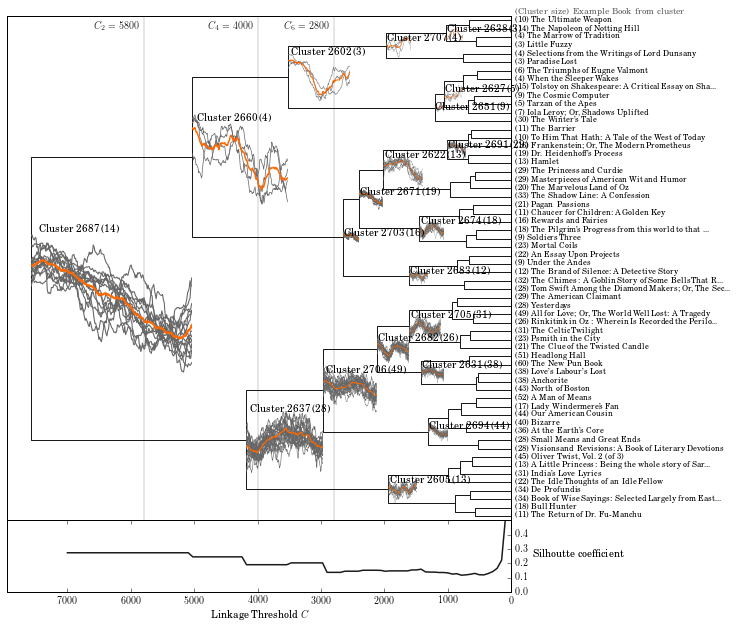

In [42]:
from matplotlib.colors import rgb2hex

def printcolor(k,yes='yes',fit=fit):
    # print('node {0} index {1}'.format(k-fit.shape[0],k-fit.shape[0]-1))
    return rgb2hex(cm(fit[k-fit.shape[0]-1,2]/fit[-1,2]))

def llf(k):
    chars = 50
    all_ind = get_cluster_indices_from_id(fit,k)
#     print(k,all_ind)
    # go get the submatrix
    # allDistances[[1,2,3],:][:,[1,2,3]]
    submat = allDistances[all_ind,:][:,all_ind]
#     print(submat)
    distances = submat.sum(axis=0)
#     print(distances)
    indices_sorted = sorted(range(len(all_ind)),key=lambda i: distances[i])
    all_ind_sorted = all_ind[indices_sorted]
#     print(all_ind_sorted)
#     print(all_ind_sorted[0])
    if len(all_ind_sorted) == 0:
        print("no book found?")
        print(k)
    b = q[int(all_ind_sorted[0])]
    # b = q[627]
    if len(b.title) > chars:
        s = "({}) {}...".format(len(all_ind),b.title[:chars-3].replace("\n",": ").replace("&","\&"))
    else:
        s = "({}) {}".format(len(all_ind),b.title.replace("\n",": ").replace("&","\&"))
    # print('node {0} index {1}'.format(k-fit.shape[0],k-fit.shape[0]-1))
    s = s.encode("ascii","ignore").decode("ascii")
    return s
    

# R = dendrogram(fit,
#                p=p,
#                truncate_mode='lastp',
#                link_color_func=lambda k: printcolor(k,yes='n'),
#                ax=ax,
#                # leaf_rotation=0.,
#                # labels=alltitles,
#                # leaf_label_func=llf,
#                # leaf_label_func=lambda k: q[k].title,
#                # orientation='right',
#                orientation='top',
#                # no_labels=True,
#                )

p=60
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([.2,.2,.7,.7])
# ax.set_xscale('log',basex=10)
# ax.set_xlim([50,10000])
# ax.set_xlim(np.log10([50,10000]))
# colors = ["k" for i in range(p+1)]
R = dendrogram(fit,
               p=p,
               link_color_func=lambda k: "0.1",
               truncate_mode="lastp",
               orientation="left",
               distance_sort="ascending",
               ax=ax,
               # leaf_label_func=lambda k: k-fit.shape[0]+1,
               leaf_label_func=llf,
               leaf_font_size=8,
               # link_color_func=lambda k: colors[k],
               # annotate_above=10000,
               )

y_range = ax.get_ylim()
def add_line(x,i):
    ax.plot([x,x],y_range,zorder=1,color=".9",linewidth=2)
    # example from mpl
#     bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="cyan", ec="b", lw=2)
#     t = ax.text(0, 0, "Direction", ha="center", va="center", rotation=45,
#             size=15,
#             bbox=bbox_props)
    bbox_props = dict(boxstyle="square,pad=0.3", fc=".9", ec=".6", lw=1)
    ax.text(x+80,y_range[1]-8,"{}".format(i),color=".1",ha="right",va="top",linespacing=1.8,size=10) # ,bbox=bbox_props)
# thresholds = [29000,20000,11000,5500]
ax.text(-60,y_range[1]+3,"(Cluster size) Example Book from cluster",color=".4",size=9)

for i,d,c in zip(R['icoord'],R['dcoord'],R['leaves']):
    y = 0.5 * sum(i[1:3])
    # print(i)
    x = d[1]
#     print(d)
#     print(i)
    # print(d)
    # print(x,y)
    # ax.plot(y,x, 'ro')
#     plt.annotate("%.3g" % y, (x, y), xytext=(0, -8),
#                  textcoords='offset points',
#                  va='top', ha='center')
    if x>0:
        # ax.text(x-30,y,c,color="0",ha="left",va="top",linespacing=1.8,size=10)
        
#         subx = fig.add_axes([ax.transLimits.transform_point([d[1],i[0]])[0],
#                              ax.transLimits.transform_point([d[1],i[0]])[1],
#                              ax.transLimits.transform_point([d[0],i[1]])[0],
#                              ax.transLimits.transform_point([d[0],i[1]])[0]])
        
        rects = [ax.get_xlim()[0]-np.min([d[1]-d[0],d[2]-d[3]]),i[2]-i[1]]
        rects_notflipped = [np.min([d[1]-d[0],d[2]-d[3]]),i[2]-i[1]]
#         print(rects)
        max_size_ax = ax.transLimits.transform_point(rects)
        # max_size_ax[0] = 1-max_size_ax
        # print(max_size_ax)
        max_size_ax = np.min(max_size_ax)
        b_left = np.array([x,y])
        b_ax = ax.transLimits.transform_point(b_left)+np.array([0,-max_size_ax/2])
        # b_ax[0] += .1*max_size_ax
        b_ax_subrect = .2+.7*b_ax
#         print(max_size_ax)
#         print(b_ax)
        subx = fig.add_axes([b_ax_subrect[0],b_ax_subrect[1],max_size_ax*.7,max_size_ax*.7],frameon=False)
        # subx.plot()
        ind = get_cluster_indices_from_id(fit,c)
        j = 0
        for index in ind:
            if j+1 > 20:
                break
            # ax1.plot(data[index],label="{} ({})".format(title.encode("ascii","ignore").decode("ascii"),q[int(index)].gutenberg_id))
            subx.plot(big_matrix_mean0[index],color=".4",label=None,linewidth=x/7000.)
            # ax1books.text(0.0,.8-j*.2,"{} ({})".format(title.encode("ascii","ignore").decode("ascii"),q[int(index)].gutenberg_id),fontsize=10)
            j+=1
        subx.plot(big_matrix_mean0[ind,:].mean(axis=0),
                 color="#ff6700",
                 linewidth=x/3500.,
                 label="Cluster {} ({})".format(c,len(ind)))
        subx.text(.05,.95,"Cluster {} ({})".format(c,len(ind)),
                  color="0",ha="left",va="top",
                  # linespacing=1.8,
                  size=x*10/7000,
                  transform=subx.transAxes)
        subx.set_xticks([])
        subx.set_yticks([])
#     print("="*40)
        

# subx = fig.add_axes([.2,.5,.1,.1])

thresholds = [5800,4000,2800]
nc = [2,4,6]
for i,t in enumerate(thresholds):
    # add_line(t,i)
    # add_line(t,"$C_{1} = {0}$\n{1} Clusters".format(t,nc[i]))
    add_line(t,"$C_{1} = {0}$".format(t,nc[i]))
# ax.set_xlim(np.log10([50,10000]))
# ax.set_xlim([400,11000])
ax.set_xticks([])
ax2 = fig.add_axes([.2,.1,.7,.1])
ax2.plot(sil_x,sil_vals,'.1',linewidth=1.5)
ax2.set_xlim(ax.get_xlim())
ax2.yaxis.tick_right()
# ax2.set_ylim([0,1])
# ax2.set_yticks([0,.2,.4,.6,.8])
ax2.set_ylim([0,.5])
ax2.set_yticks([0,.1,.2,.3,.4])
# ax2.set_ylabel("Silhoutte coefficient")
ax2.text(-350,.25,"Silhoutte coefficient")
ax2.set_xlabel("Linkage Threshold $C$")
# mysavefig("dendrogram-left-p{}-topstories.pdf".format(p),openfig=True,date_prefix=True,folder=this_dir)

In [74]:
ax.transLimits

BboxTransformFrom(TransformedBbox(Bbox([[7950.136278141014, 0.0], [0.0, 600.0]]), TransformWrapper(BlendedAffine2D(IdentityTransform(),IdentityTransform()))))

In [80]:
ax.transAxes.transform_point([1,0])

array([ 720.,  240.])

In [77]:
ax.transLimits.transform_point([7950.13,0])

array([  7.89689735e-07,   0.00000000e+00])

In [78]:
ax.transLimits.transform

array([ 1.,  0.])

In [79]:
ax.transScale.transform_point([7950.13,0])

array([ 7950.13,     0.  ])

In [ ]:
ax.get_

In [30]:
def get_cluster_indices2(model,threshold=70000):
    cluster_list = np.arange(allDistances.shape[0],dtype=int)
    # march through the model and cluster the stories as they are clustered in each step of model
    i = 0
    merge = model[i]
    while merge[2] < threshold:
        # print(merge)
        # print(int(merge[0]))
        a = cluster_list==int(merge[0])
        cluster_list[cluster_list==int(merge[0])] = i+allDistances.shape[0]
        cluster_list[cluster_list==int(merge[1])] = i+allDistances.shape[0]
        i+=1
        merge = model[i]
        
    # print(cluster_list[:10])
    # print(cluster_list[1730:1740])
    clusters = np.unique(cluster_list)
    a = np.arange(allDistances.shape[0],dtype=int)
    indices = [a[cluster_list==c] for c in clusters]
    # num_clusters = len(indices)
    # cluster_sizes = list(map(len,indices))
    # print('found {0} clusters of sizes:'.format(num_clusters))
    # print(cluster_sizes)
    return indices,cluster_list

def get_sorted(all_ind):
    # go get the submatrix
    # allDistances[[1,2,3],:][:,[1,2,3]]
    submat = allDistances[all_ind,:][:,all_ind]
    # print(submat)
    distances = submat.sum(axis=0)
    # print(distances)
    indices_sorted = sorted(range(len(all_ind)),key=lambda i: distances[i])
    all_ind_sorted = all_ind[indices_sorted]
    distances_sorted = distances[indices_sorted]
    # print(all_ind_sorted)
    # make sure they're sorted the right way!
    # print(distances_sorted)
    assert distances_sorted[0] < distances_sorted[1]
    titles_sorted = ["" for i in range(len(all_ind_sorted))]
    chars = 50
    for i,ind in enumerate(all_ind_sorted):
        b = q[int(ind)]
        if len(b.title) > chars:
            titles_sorted[i] = "{}. {}...".format(i+1,b.title[:chars-3].replace("\n",": "))
        else:
            titles_sorted[i] = "{}. {}".format(i+1,b.title.replace("\n",": "))
    return all_ind_sorted,titles_sorted
    
    
for i,t in enumerate(thresholds[:1]):
    # add_line(t,i)
    ind,cluster_list = get_cluster_indices2(fit,threshold=t)
    # ind,nc,cs = get_cluster_indices(fit,threshold=t)
    print(ind)
    # the indices...
    print(cluster_list)
    # for each story, which cluster it is in, by id (a reverse lookup of ind)
    ind_sorted,titles_sorted = get_sorted(ind[0])
    print(ind_sorted[:10])
    print(titles_sorted[:10])

[array([   2,    6,    9,   25,   29,   30,   34,   40,   43,   44,   46,
         48,   58,   60,   65,   70,   74,   81,   86,   88,   89,   94,
         97,  103,  104,  108,  117,  128,  129,  139,  140,  141,  154,
        157,  163,  165,  173,  175,  183,  184,  187,  192,  200,  211,
        224,  228,  229,  236,  243,  250,  255,  256,  261,  271,  290,
        307,  312,  314,  323,  326,  330,  332,  333,  336,  346,  366,
        369,  381,  398,  408,  409,  413,  419,  430,  441,  442,  444,
        453,  461,  466,  472,  481,  482,  484,  488,  491,  504,  522,
        523,  526,  527,  550,  553,  555,  559,  563,  567,  586,  587,
        591,  604,  608,  614,  615,  622,  630,  634,  642,  650,  651,
        661,  663,  664,  667,  671,  673,  683,  695,  698,  700,  702,
        705,  707,  708,  709,  711,  714,  715,  721,  724,  725,  735,
        738,  751,  755,  760,  761,  766,  767,  770,  772,  776,  777,
        785,  794,  804,  817,  822,  823,  829,  

In [31]:
# now let's also plot them
def plot_clusters(clusters,data,v=True,fix_ylim=True,xspacing=.01,investigate=False,save=False,threshold=1000):
    # we are going to make plots of max width 3
    num_x = np.min([3,len(clusters)])
    num_y = np.ceil(len(clusters)/num_x)
    xspacing = .03
    yspacing = .03
    xoffset = .07
    yoffset = .07
    xwidth = (1.-xoffset)/(num_x)-xspacing
    yheight = (1.-yoffset)/(num_y)-yspacing
    print('xwidth is {0}'.format(xwidth))
    print('yheight is {0}'.format(yheight))
    
    # go compute the ybounds:
    calc_ylim = [100.0,-100.0]
    for cluster in clusters:
        c_max = data[cluster[0][:20],:].max()
        c_min = data[cluster[0][:20],:].min()
        calc_ylim[0] = np.min([calc_ylim[0],c_min])
        calc_ylim[1] = np.max([calc_ylim[1],c_max])
        
    chars = 60
    
    scale_factor_x = 5
    scale_factor_y = 5*1.25
    if investigate:
        scale_factor_x = 10
        scale_factor_y = 10*1.25
    fig = plt.figure(figsize=(scale_factor_x*num_x,scale_factor_y*num_y))
    for i,cluster in enumerate(clusters):
        print(i)
        print("====")
        # print((i-i%num_x))
        # ind = np.argsort(w[:,sv+svstart])[-20:]
        ax1rect = [xoffset+(i%num_x)*(xspacing+xwidth),1.-yheight-yspacing-(int(np.floor((i-i%num_x)/num_x))*(yspacing+yheight))+yheight*.2,xwidth,yheight*.8]
        ax1 = fig.add_axes(ax1rect)
        ax1books_rect = ax1rect.copy()
        ax1books_rect[1] -= yheight*.2
        ax1books_rect[3] = yheight*.2
        ax1books = fig.add_axes(ax1books_rect)
        # ax1books.text?
        # ax.set_title('20 closest positive correlates')
        
        if v:
            print('-'*80)
            print('20 closest positive correlates:')
            # print(cluster)
        j=0
        for index,title in zip(*cluster):
            if j+1 > 20:
                break
            if investigate:
                ax1.plot(data[index],label="{} ({})".format(title.encode("ascii","ignore").decode("ascii"),q[int(index)].gutenberg_id))
            else:
                ax1.plot(data[index],color=".4",label=None)
            # plt.plot(big_matrix_mean0[i],color=".4")
            if v:
                print(index,title)
            if j<5:
                ax1books.text(0.0,.8-j*.2,"{} ({})".format(title.encode("ascii","ignore").decode("ascii"),q[int(index)].gutenberg_id),fontsize=10)
            j+=1
        ax1.plot(data[cluster[0],:].mean(axis=0),color="#ff6700",linewidth=2,label="Threshold {} Cluster {} ({})".format(threshold,i+1,len(cluster[0])))
        # ax1.set_xticklabels([])
        ax1.legend(loc="upper right")

        # ax1.axis('off')
        ax1books.axis('off')
        
        props = dict(boxstyle='square', facecolor='white', alpha=1.0)
        # fig.text(ax1rect[0]+.03/xwidth, ax1rect[1]+ax1rect[3]-.03/yheight, letters[i],
        if fix_ylim:
            my_ylim = calc_ylim
        else:
            my_ylim = ax1.get_ylim()
        ax1.text(.035*200, my_ylim[0]+.965*(my_ylim[1]-my_ylim[0]), letters[i],
                     fontsize=14,
                     verticalalignment='top',
                     horizontalalignment='left',
                     bbox=props)

        if fix_ylim:
            ax1.set_ylim(calc_ylim)
        if fix_ylim and i%num_x > 0:
            ax1.set_yticklabels([])
        if True: # i<num_x*(num_y-1): # only on the bottom row
            ax1.set_xticklabels([])
            
    if save:
        # mysavefig('SV{0}.svg'.format('4-6'))
        mysavefig("clustered-timeseries-threshold-{}-num-{}.png".format(t,len(clusters)),
                  folder=this_dir,
                  openfig=False)
        mysavefig("clustered-timeseries-threshold-{}-num-{}.pdf".format(t,len(clusters)),
                  folder=this_dir,
                  openfig=True)

xwidth is 0.43499999999999994
yheight is 0.8999999999999999
0
====
1
====
xwidth is 0.28
yheight is 0.43499999999999994
0
====
1
====
2
====
3
====
xwidth is 0.28
yheight is 0.28
0
====
1
====
2
====
3
====
4
====
5
====
6
====
7
====
8
====


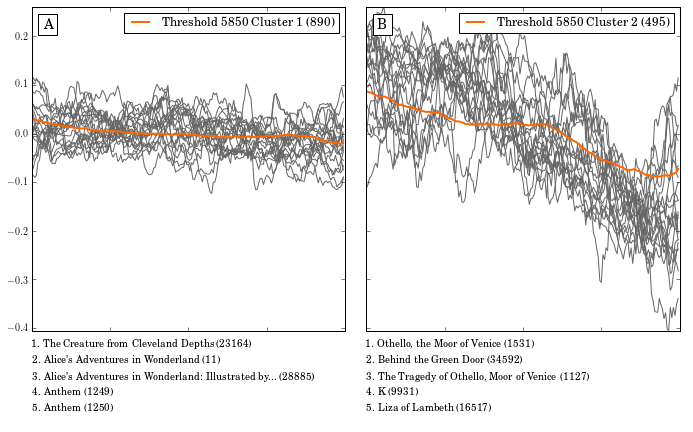

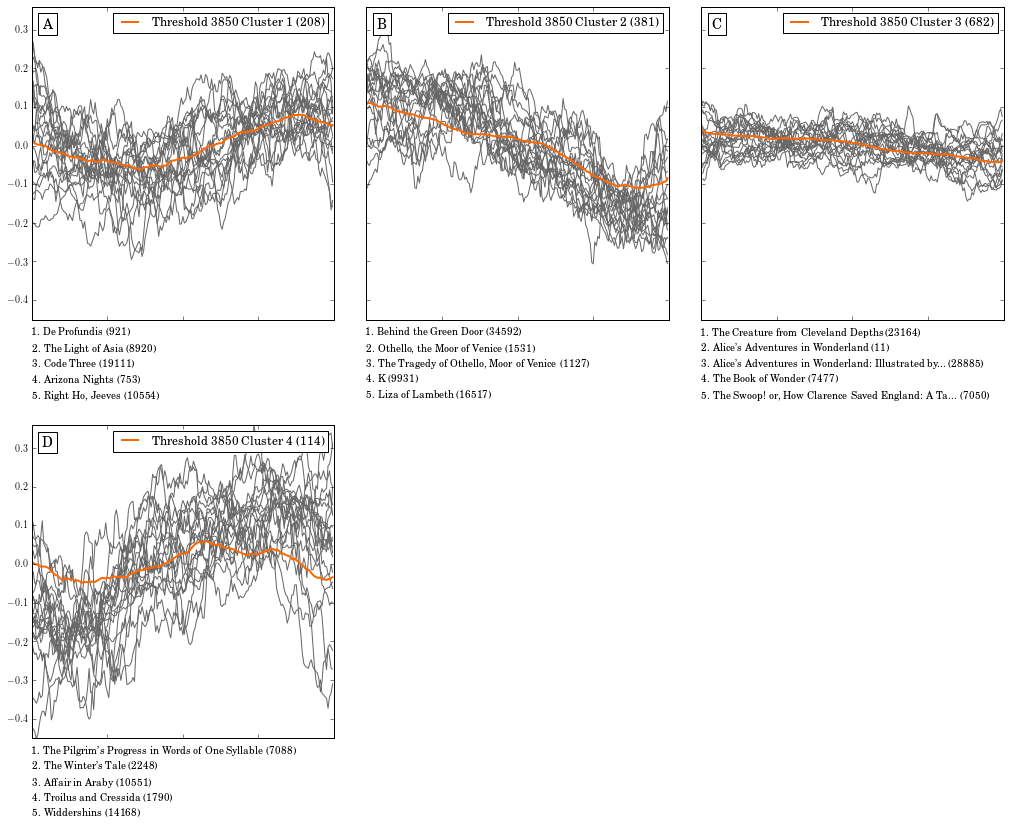

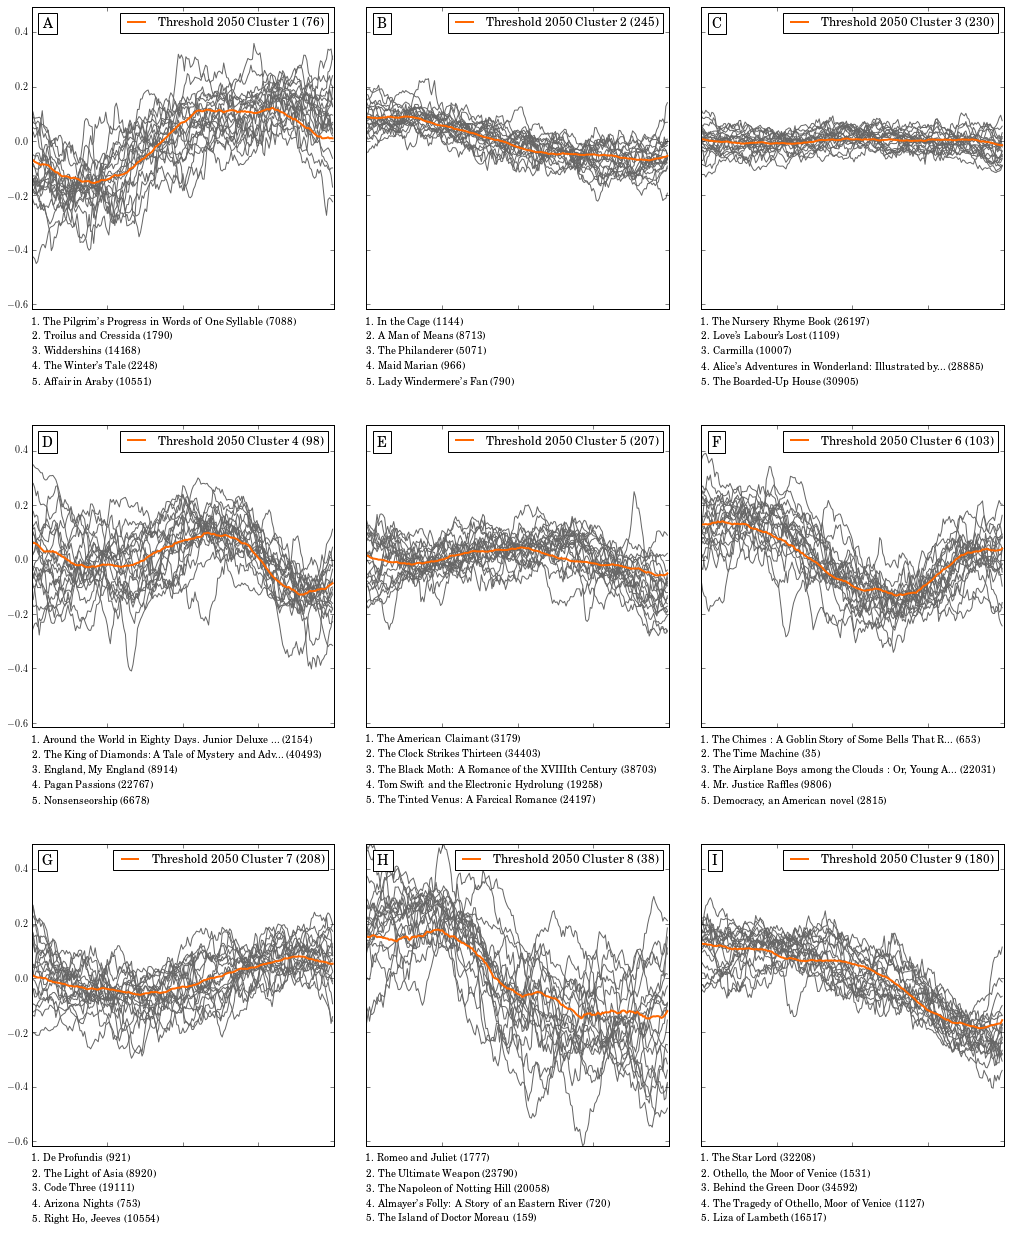

In [32]:
for i,t in enumerate(thresholds):
    # add_line(t,i)
    ind,cluster_list = get_cluster_indices2(fit,threshold=t)
    # ind,nc,cs = get_cluster_indices(fit,threshold=t)
    # print(ind)
    # the indices...
    # print(cluster_list)
    # for each story, which cluster it is in, by id (a reverse lookup of ind)
    ind_sorted,titles_sorted = get_sorted(ind[0])
    # print(ind_sorted[:10])
    # print(titles_sorted[:10])
    
    # go and sort all of them
    ind_sorted_all = [get_sorted(i) for i in ind]
    # print(ind_sorted_all)
    
    # now let's try our new plotting function
    plot_clusters(ind_sorted_all,big_matrix_mean0,v=False,save=True,threshold=t) #,fix_ylim=[5.5,5.8])

In [32]:
def get_cluster_indices3(model,threshold):
    cluster_list = np.arange(allDistances.shape[0],dtype=int)
    # march through the model and cluster the stories as they are clustered in each step of model
    i = 0
    merge = model[i]
    while merge[2] < threshold:
        # print(merge)
        # print(int(merge[0]))
        a = cluster_list==int(merge[0])
        cluster_list[cluster_list==int(merge[0])] = i+allDistances.shape[0]
        cluster_list[cluster_list==int(merge[1])] = i+allDistances.shape[0]
        i+=1
        merge = model[i]
    return cluster_list

In [33]:
sil_x = np.linspace(7000,10,100)
print(sil_x)
sil_vals = np.zeros(len(sil_x))
for i in tqdm(range(len(sil_x))):
    # print(j)
    sil_vals[i] = metrics.silhouette_score(allDistancesCentered, get_cluster_indices3(fit,sil_x[i]), metric='euclidean')  
# y = [metrics.silhouette_score(allDistancesCentered, get_cluster_indices3(fit,i), metric='euclidean') for i in x]

100%|██████████| 100/100 [01:47<00:00, 10.95s/it]

[ 7000.          6929.39393939  6858.78787879  6788.18181818  6717.57575758
  6646.96969697  6576.36363636  6505.75757576  6435.15151515  6364.54545455
  6293.93939394  6223.33333333  6152.72727273  6082.12121212  6011.51515152
  5940.90909091  5870.3030303   5799.6969697   5729.09090909  5658.48484848
  5587.87878788  5517.27272727  5446.66666667  5376.06060606  5305.45454545
  5234.84848485  5164.24242424  5093.63636364  5023.03030303  4952.42424242
  4881.81818182  4811.21212121  4740.60606061  4670.          4599.39393939
  4528.78787879  4458.18181818  4387.57575758  4316.96969697  4246.36363636
  4175.75757576  4105.15151515  4034.54545455  3963.93939394  3893.33333333
  3822.72727273  3752.12121212  3681.51515152  3610.90909091  3540.3030303
  3469.6969697   3399.09090909  3328.48484848  3257.87878788  3187.27272727
  3116.66666667  3046.06060606  2975.45454545  2904.84848485  2834.24242424
  2763.63636364  2693.03030303  2622.42424242  2551.81818182  2481.21212121
  2410.606060

(7000, 0)

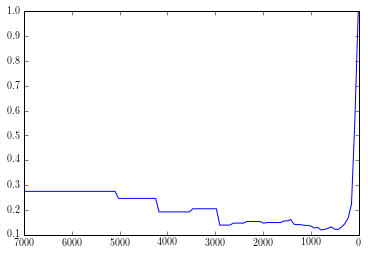

In [34]:
plt.plot(sil_x,sil_vals)
plt.xlim([7000,0])

In [35]:
sil_vals

array([ 0.27404674,  0.27404674,  0.27404674,  0.27404674,  0.27404674,
        0.27404674,  0.27404674,  0.27404674,  0.27404674,  0.27404674,
        0.27404674,  0.27404674,  0.27404674,  0.27404674,  0.27404674,
        0.27404674,  0.27404674,  0.27404674,  0.27404674,  0.27404674,
        0.27404674,  0.27404674,  0.27404674,  0.27404674,  0.27404674,
        0.27404674,  0.27404674,  0.27404674,  0.24565135,  0.24565135,
        0.24565135,  0.24565135,  0.24565135,  0.24565135,  0.24565135,
        0.24565135,  0.24565135,  0.24565135,  0.24565135,  0.24565135,
        0.19115451,  0.19115451,  0.19115451,  0.19115451,  0.19115451,
        0.19115451,  0.19115451,  0.19115451,  0.19115451,  0.19115451,
        0.20379803,  0.20379803,  0.20379803,  0.20379803,  0.20379803,
        0.20379803,  0.20379803,  0.20379803,  0.13798199,  0.13798199,
        0.13798199,  0.13798199,  0.14593893,  0.14593893,  0.14593893,
        0.14593893,  0.15262675,  0.15262675,  0.15262675,  0.15

In [53]:
import matplotlib.cm as cm
def sil_plot(t):
    cluster_labels = get_cluster_indices3(fit,t)
    silhouette_avg = metrics.silhouette_score(allDistancesCentered, get_cluster_indices3(fit,t))
    sample_silhouette_values = metrics.silhouette_samples(allDistancesCentered, get_cluster_indices3(fit,t))
    y_lower = 10
    n_clusters = len(np.unique(cluster_labels))
    fig = plt.figure(figsize=(8,15))
    ax1 = fig.add_axes([.2,.2,.7,.7])
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(allDistancesCentered[0,:]) + (n_clusters + 1) * 10])
    for i,c in enumerate(np.unique(cluster_labels)):
        # print(c)
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == c]
        # print(len(sample_silhouette_values[cluster_labels == c]))

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.09, y_lower + 0.5 * size_cluster_i, str(c))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [54]:
cluster_indices = get_cluster_indices3(fit,5000)

In [55]:
cluster_indices

array([2766, 2766, 2766, ..., 2766, 2766, 2766])

In [56]:
np.unique(cluster_indices)

array([2763, 2765, 2766])

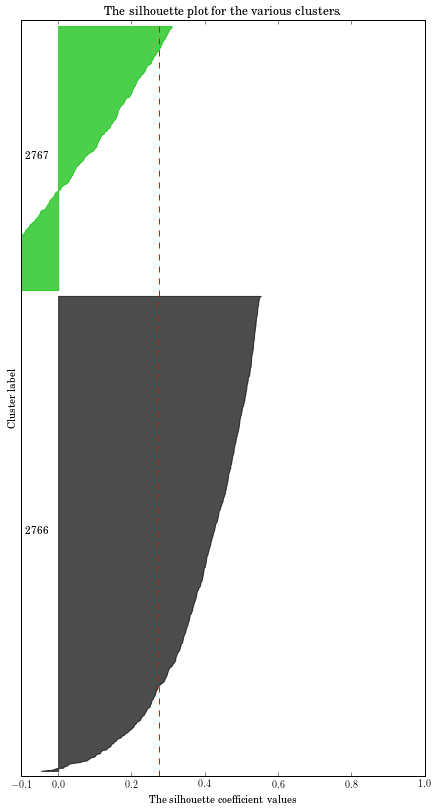

In [57]:
sil_plot(6000)

In [58]:
import matplotlib.cm as cm
def find_threshold(n_clusters):
    t = 7500
    step = 500
    n = 1
    while n != n_clusters:
        if n>n_clusters:
            t = t + step
            step = step/2.0
        if n<n_clusters:
            t = t - step
        # for my own amusement
        # print(t)
        cluster_labels = get_cluster_indices3(fit,t)
        n = len(np.unique(cluster_labels))
    return t
def sil_plot_nc(n_clusters):
    t = find_threshold(n_clusters)
    # print(t)
    silhouette_avg = metrics.silhouette_score(allDistancesCentered, get_cluster_indices3(fit,t))
    sample_silhouette_values = metrics.silhouette_samples(allDistancesCentered, get_cluster_indices3(fit,t))
    y_lower = 10
    n_clusters = len(np.unique(cluster_labels))
    fig = plt.figure(figsize=(4,6))
    ax1 = fig.add_axes([.2,.2,.7,.7])
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(allDistancesCentered[0,:]) + (n_clusters + 1) * 10])
    cluster_labels_uniq = np.unique(cluster_labels)
    cluster_labels_uniq.sort()
    for i,c in enumerate(cluster_labels_uniq):
        # print(c)
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == c]
        # print(len(sample_silhouette_values[cluster_labels == c]))

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        # color = cm.spectral(float(i) / n_clusters)
        color=".5"
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.09, y_lower + 0.5 * size_cluster_i, str(c))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette plot for the $N={}$ clusters.".format(n_clusters))
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    mysavefig("silhouette-distribution-{}.pdf".format(n_clusters),
                  folder=this_dir,
                  openfig=False)

In [59]:
for i in range(2,12):
    sil_plot_nc(i)

NameError: name 'cluster_labels' is not defined